In [4]:
import numpy as np
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
# ! pip install git+https://github.com/davidbau/baukit
# ! pip install torchinfo tqdm matplotlib
# ! unzip -q flat_spectrograms.zip
#! unzip -q train_val_test2.zip

In [5]:
from baukit import show
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_path = "train_val_test2/train" # "data/spectrograms/train"
val_path = "train_val_test2/val"
print(device)
# test_path = "mnist_4440/test"
# train_set = ImageFolder(train_path)
# print("Number of images in the training set =", len(train_set))

cuda


In [6]:
from torchvision import transforms

class mapping_transform(object):
  def __init__(self, num_labels):
    self.num_labels = num_labels

  def __call__(self, labels):    
    return mapping[labels]#new_label

mapping = {0: 0, 1: 0, 2: 1, 3: 3, 4: 0, 5: 2}

img_size = 256
train_set = torchvision.datasets.ImageFolder(
    train_path, 
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=1), ToTensor(), transforms.Resize((img_size, img_size))
    ]),
    target_transform=mapping_transform(num_labels=4)#transforms.Lambda(lambda y: mapping_transform(y)),
)
print('a')
val_set = torchvision.datasets.ImageFolder(
    val_path, 
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=1), ToTensor(), transforms.Resize((img_size, img_size))
    ]),
    target_transform=mapping_transform(num_labels=4)#transforms.Lambda(lambda y: mapping_transform(y)),
)

print('b')

val_set = torchvision.datasets.ImageFolder(
    val_path, 
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=1), ToTensor(), transforms.Resize((img_size, img_size))
    ]),
    target_transform=mapping_transform(num_labels=4)#transforms.Lambda(lambda y: mapping_transform(y)),
)
train_set.targets = [mapping[t] for t in train_set.targets]
val_set.targets = [mapping[t] for t in val_set.targets]
train_set.classes = ["Background", "Fish", "Vessel", "Mn"]
val_set.classes = ["Background", "Fish", "Vessel", "Mn"]

a
b


In [28]:
img, label = train_set[1189]
len(train_set), len(val_set)
# now the image is a tensor
# img.resize((3, 256, 256))
# img#.shape
# torchvision.transforms.Resize((256, 256))(img)

(75705, 10815)

In [29]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=512,
    shuffle=True,
    num_workers=16,
    pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=512,
    shuffle=True,
    num_workers=16,
    pin_memory=True,
)

In [30]:
images, labels = next(train_loader.__iter__())
print(f"{images.shape=}, {labels.shape=}")

images.shape=torch.Size([512, 1, 256, 256]), labels.shape=torch.Size([512])


In [31]:
# ## Some helper functions to view network parameters
from torchinfo import summary

def view_network_shapes(model, input_shape):
    print(summary(model, input_size=input_shape))

def view_network_parameters(model):
    # Visualise the number of parameters
    tensor_list = list(model.state_dict().items())
    total_parameters = 0
    print("Model Summary\n")
    for layer_tensor_name, tensor in tensor_list:
        total_parameters += int(torch.numel(tensor))
        print("{}: {} elements".format(layer_tensor_name, torch.numel(tensor)))
    print(f"\nTotal Trainable Parameters: {total_parameters}!")

In [77]:
from torch import nn

def cnn_classifier():
    torch.manual_seed(4440)  # for reproducibility
    ##########################################################################
    # **Exercise 4.2.2.1**
    # TODO: Make a CNN classifier for the task wrapped in an nn.Sequential module.
    # You can vary your architecture choices (# layers, # convs, activation functions, regularization, etc.)
    # However, your parameter size should not be more than 0.5 MB. Use the `view_network_shapes` function to get the `Params size`
    drop_prob = 0.2 # 0.1
    model = nn.Sequential(
        nn.Conv2d(1, 4, kernel_size=7, padding=3, stride=3),
        nn.Dropout(p=drop_prob),
        nn.ReLU(),
        nn.BatchNorm2d(4),
        nn.Conv2d(4, 8, kernel_size=7, padding=2, stride=3),
        nn.Dropout(p=drop_prob),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, 12, kernel_size=5, padding=0, stride=2),
        nn.Dropout(p=drop_prob),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Conv2d(12, 16, kernel_size=5, padding=0, stride=2),
        nn.Dropout(p=drop_prob),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.AvgPool2d(4),
        nn.Flatten(),
        nn.Linear(16, 4),
        nn.Softmax()
    )
    ##########################################################################
    return model


model = cnn_classifier().to(device)
view_network_shapes(model, img[None].shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 4]                    --
├─Conv2d: 1-1                            [1, 4, 86, 86]            200
├─Dropout: 1-2                           [1, 4, 86, 86]            --
├─ReLU: 1-3                              [1, 4, 86, 86]            --
├─BatchNorm2d: 1-4                       [1, 4, 86, 86]            8
├─Conv2d: 1-5                            [1, 8, 28, 28]            1,576
├─Dropout: 1-6                           [1, 8, 28, 28]            --
├─ReLU: 1-7                              [1, 8, 28, 28]            --
├─BatchNorm2d: 1-8                       [1, 8, 28, 28]            16
├─Conv2d: 1-9                            [1, 12, 12, 12]           2,412
├─Dropout: 1-10                          [1, 12, 12, 12]           --
├─ReLU: 1-11                             [1, 12, 12, 12]           --
├─BatchNorm2d: 1-12                      [1, 12, 12, 12]           24
├─Conv2d:

/home/onyejekwe.b/.conda/envs/my_pytorch_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [33]:
# training the model
def train_model(model, train_loader, loss_fn, optimizer):
    model.train()
    # Initiate a loss monitor
    train_loss = []
    correct_predictions = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        loss = loss_fn(predicted, labels)
        correct_predictions += (predicted.argmax(dim=1) == labels).sum().item()

        # Backward pass (back propagation)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    return np.mean(train_loss), correct_predictions / len(train_loader.dataset)


# evaluating the model
@torch.inference_mode()  # understand what torch.inference_mode() or torch.no_grad() does
def evaluate_model(model, val_loader, loss_fn, return_confusion_matrix=False):
    model.eval()
    # Initiate a loss monitor
    val_loss = []
    correct_predictions = 0

    if return_confusion_matrix:
        confusion_matrix = torch.zeros(
            len(val_loader.dataset.classes), len(val_loader.dataset.classes)
        )

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        loss = loss_fn(predicted, labels)
        correct_predictions += (predicted.argmax(dim=1) == labels).sum().item()

        if return_confusion_matrix:
            for t, p in zip(labels.view(-1), predicted.argmax(dim=1).view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        val_loss.append(loss.item())

    val_loss = np.mean(val_loss)
    val_acc = correct_predictions / len(val_loader.dataset)

    if return_confusion_matrix:
        return val_loss, val_acc, confusion_matrix
    else:
        return val_loss, val_acc

In [34]:
train_set.classes

['Background', 'Fish', 'Vessel', 'Mn']

100%|██████████| 148/148 [00:37<00:00,  4.00it/s]


Text(0.5, 1.0, 'Distribution of Classes in Training Set')

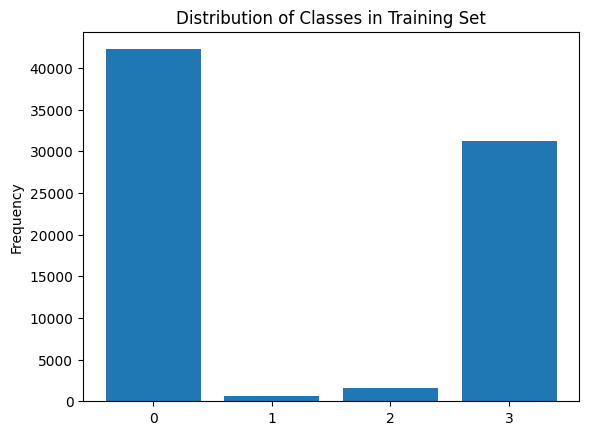

In [35]:
# plot the data distribution in the training set

from tqdm import tqdm
from matplotlib import pyplot as plt

counter = torch.zeros(len(train_set.classes))
for images, labels in tqdm(train_loader):
    for label in labels:
        counter[label] += 1

##########################################################
# **Exercise 4.2.1.2**
# TODO: Plot the distribution of classes in the training set as a bar plot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
plt.bar(list(range(len(counter))), counter)
plt.xticks(range(4))
plt.ylabel("Frequency")
plt.title("Distribution of Classes in Training Set")

# raise NotImplementedError

##########################################################

In [36]:
counter / sum(counter)
# ([0.2925, 0.0037, 0.0035, 0.6709, 0.0051, 0.0242])

tensor([0.5580, 0.0083, 0.0205, 0.4131])

In [37]:
weight = max(counter) / counter
weight
# weight + torch.ones(weight.shape)
# 2.7960e+00, 2.0886e+03, 1.4919e+02, 1.0000e+00, 7.7643e+01, 3.8678e+01

tensor([ 1.0000, 67.0556, 27.1847,  1.3507])

In [38]:
(max(counter) / counter) ** .5

tensor([1.0000, 8.1887, 5.2139, 1.1622])

In [76]:
(max(counter) / counter) ** .75

tensor([ 1.0000, 23.4329, 11.9054,  1.2529])

In [80]:
torch.manual_seed(4440)

model = cnn_classifier().to(device)
epochs = 20  # your model should be able to get > 98% validation accuracy on the first 10 epochs
####################################################################
# **Exercise 4.2.2.2**
# TODO: choose values for your hyperparameters
learning_rate = 0.01 #0.005 # None
weight_decay = 0.0001 # None
# TODO: choose a loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(weight = (weight ** 0.6).to(device), label_smoothing=0.1) #None
# loss_fn = torch.nn.CrossEntropyLoss(weight = (max(counter) / counter) ** .5) #None
# loss_fn = torch.nn.CrossEntropyLoss() #None
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # None
####################################################################

training_losses = []
validation_losses = []

for epoch in range(epochs):
    train_loss, train_acc = train_model(model, train_loader, loss_fn, optimizer)
    training_losses.append(train_loss)
    val_loss, val_acc = evaluate_model(model, val_loader, loss_fn)
    validation_losses.append(val_loss)
    print(
        f"epoch: {epoch+1}/{epochs} | train loss={np.mean(train_loss):.4f}, {train_acc=:.4f} | val loss: {np.mean(val_loss):.4f}, {val_acc=:.4f}"
    )

/home/onyejekwe.b/.conda/envs/my_pytorch_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch: 1/20 | train loss=1.7084, train_acc=0.7177 | val loss: 1.6876, val_acc=0.7775
epoch: 2/20 | train loss=1.6223, train_acc=0.8167 | val loss: 1.6240, val_acc=0.7715
epoch: 3/20 | train loss=1.5987, train_acc=0.8161 | val loss: 1.5667, val_acc=0.8102
epoch: 4/20 | train loss=1.5850, train_acc=0.8136 | val loss: 1.5671, val_acc=0.8402
epoch: 5/20 | train loss=1.5811, train_acc=0.8169 | val loss: 1.6114, val_acc=0.8053
epoch: 6/20 | train loss=1.5737, train_acc=0.8227 | val loss: 1.5741, val_acc=0.8587
epoch: 7/20 | train loss=1.5657, train_acc=0.8275 | val loss: 1.5398, val_acc=0.8350
epoch: 8/20 | train loss=1.5593, train_acc=0.8317 | val loss: 1.5352, val_acc=0.8477
epoch: 9/20 | train loss=1.5549, train_acc=0.8344 | val loss: 1.5609, val_acc=0.8664
epoch: 10/20 | train loss=1.5559, train_acc=0.8318 | val loss: 1.5351, val_acc=0.8736
epoch: 11/20 | train loss=1.5544, train_acc=0.8335 | val loss: 1.5477, val_acc=0.8801
epoch: 12/20 | train loss=1.5494, train_acc=0.8383 | val loss: 

Exception in thread Thread-182 (_pin_memory_loop):
Traceback (most recent call last):
  File "/home/onyejekwe.b/.conda/envs/my_pytorch_env/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/onyejekwe.b/.conda/envs/my_pytorch_env/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/onyejekwe.b/.conda/envs/my_pytorch_env/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 53, in _pin_memory_loop
    do_one_step()
  File "/home/onyejekwe.b/.conda/envs/my_pytorch_env/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 30, in do_one_step


KeyboardInterrupt: 

    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/onyejekwe.b/.conda/envs/my_pytorch_env/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/home/onyejekwe.b/.conda/envs/my_pytorch_env/lib/python3.10/site-packages/torch/multiprocessing/reductions.py", line 495, in rebuild_storage_fd
    fd = df.detach()
  File "/home/onyejekwe.b/.conda/envs/my_pytorch_env/lib/python3.10/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/onyejekwe.b/.conda/envs/my_pytorch_env/lib/python3.10/multiprocessing/resource_sharer.py", line 86, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/home/onyejekwe.b/.conda/envs/my_pytorch_env/lib/python3.10/multiprocessing/connection.py", line 502, in Client
    c = SocketClient(address)
  File "/home/onyejekwe.b/.conda/envs/my_pytorch_env/lib/python3.10/multiprocessing/conn

In [ ]:
# for name, param in model.named_parameters():
#     print(name, param.shape, param)

In [69]:
i_test = 8238
model(val_set[i_test][0][None].to(device)), val_set[i_test][1]
# sum([1.2310e-09, 3.0830e-07, 3.5235e-07, 1.0000e+00])
# ([9.9945e-01, 2.4925e-05, 2.6792e-05, 5.0213e-04])
# 9.9548e-01, 2.3984e-03, 2.8138e-04, 1.8368e-03

(tensor([[8.3591e-05, 5.9889e-01, 2.7221e-04, 4.0075e-01]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>),
 3)

In [19]:
# torch.save(model.state_dict(), "weights")

In [44]:
# model1 = model()
# model1.load_state_dict(torch.load("weights"))

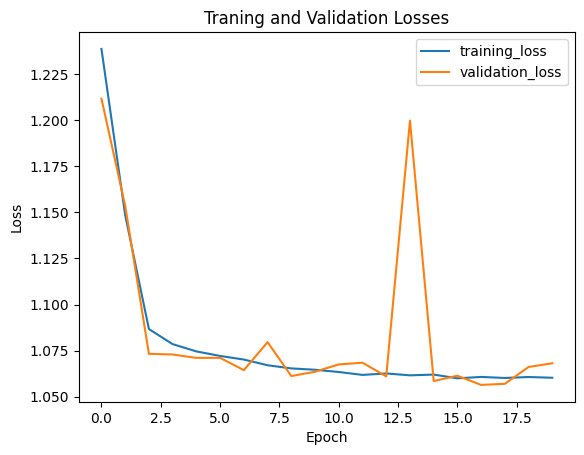

In [74]:
####################################################################
# **Exercise 4.2.2.3**
# TODO: Plot the training and validation losses vs. training epochs on the same plot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

plt.plot(range(epoch + 1), training_losses, label="training_loss")
plt.plot(range(epoch + 1), validation_losses, label="validation_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Traning and Validation Losses")
plt.legend()

#raise NotImplementedError
####################################################################

In [53]:
def draw_confusion_matrix(confusion_matrix, labels, cmap="Blues"):
    confusion_matrix = np.array(confusion_matrix)
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    assert confusion_matrix.shape[0] == len(labels)

    fig, ax = plt.subplots(figsize=(7, 7))
    plt.imshow(confusion_matrix, cmap=cmap)

    ax.set_xticks(np.arange(len(train_set.classes)), labels)
    ax.set_yticks(np.arange(len(train_set.classes)), labels)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right")

    for true_label in range(len(train_set.classes)):
        for pred_label in range(len(train_set.classes)):
            ax.text(
                pred_label,
                true_label,
                int(confusion_matrix[true_label, pred_label]),
                ha="center",
                va="center",
                color="black",
            )

    fig.tight_layout()
    plt.show()

val_loss=1.7775312662124634, val_acc=0.8681460933888119


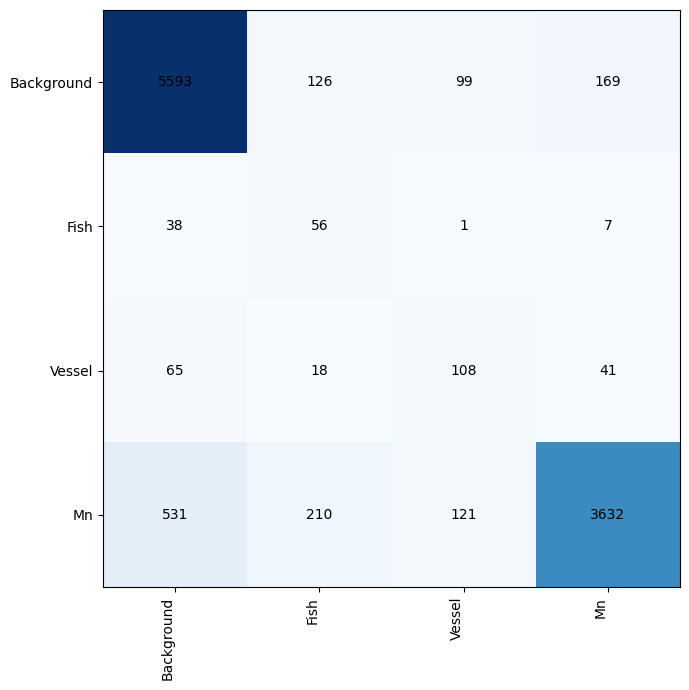

In [30]:
val_loss, val_acc, confusion_matrix = evaluate_model(
    model, val_loader, loss_fn, return_confusion_matrix=True
)
print(f"{val_loss=}, {val_acc=}")
draw_confusion_matrix(confusion_matrix, train_set.classes)
# loss = (max(counter) / counter) ** .5, label_smoothing=0.2, dropout=0.2

val_loss=1.3518461151556536, val_acc=0.888673139158576


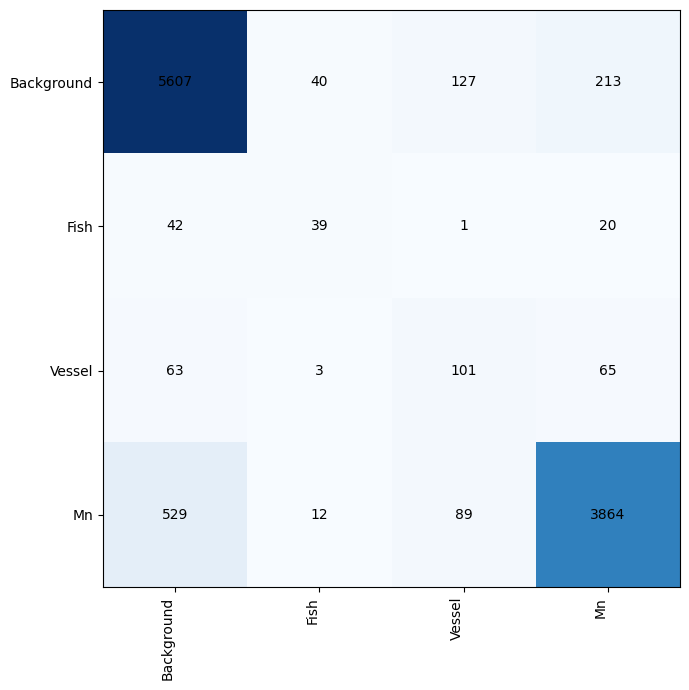

In [26]:
val_loss, val_acc, confusion_matrix = evaluate_model(
    model, val_loader, loss_fn, return_confusion_matrix=True
)
print(f"{val_loss=}, {val_acc=}")
draw_confusion_matrix(confusion_matrix, train_set.classes)
# loss = (max(counter) / counter) ** .5, label_smoothing=0.1, dropout=0.2

val_loss=0.9619583731347864, val_acc=0.8711049468331021


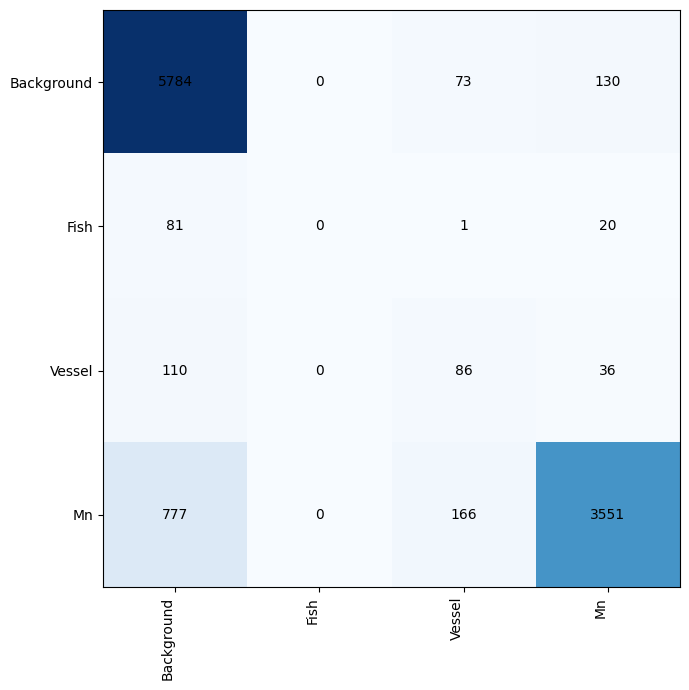

In [24]:
train_loss, train_acc, confusion_matrix = evaluate_model(
    model, val_loader, loss_fn, return_confusion_matrix=True
)
print(f"{val_loss=}, {val_acc=}")
draw_confusion_matrix(confusion_matrix, val_set.classes)
# loss = (max(counter) / counter) ** .5, label_smoothing=0, dropout=0.2

val_loss=1.3719096996567466, val_acc=0.8129449838187702


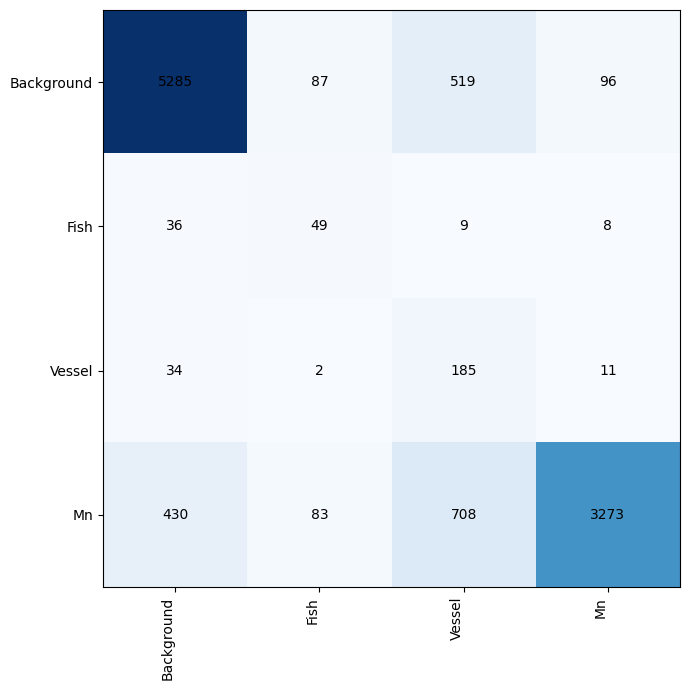

In [72]:
train_loss, train_acc, confusion_matrix = evaluate_model(
    model, val_loader, loss_fn, return_confusion_matrix=True
)
print(f"{val_loss=}, {val_acc=}")
draw_confusion_matrix(confusion_matrix, val_set.classes)
# loss = (max(counter) / counter) ** .5, label_smoothing=0.1, dropout=0.1

val_loss=1.0681408697908574, val_acc=0.8894128525196486


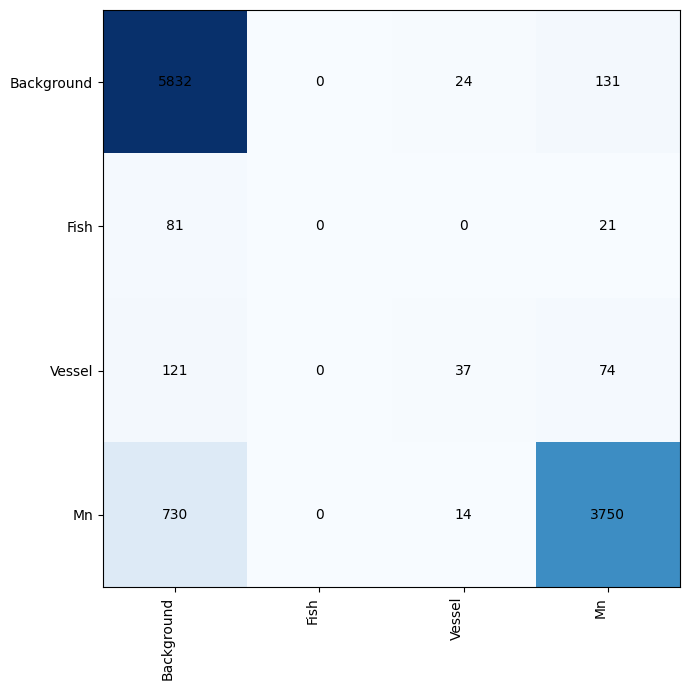

In [75]:
train_loss, train_acc, confusion_matrix = evaluate_model(
    model, val_loader, loss_fn, return_confusion_matrix=True
)
print(f"{val_loss=}, {val_acc=}")
draw_confusion_matrix(confusion_matrix, val_set.classes)
# loss = (max(counter) / counter) ** .25, label_smoothing=0.1, dropout=0.1

val_loss=1.5201840021393516, val_acc=0.8625982431807675


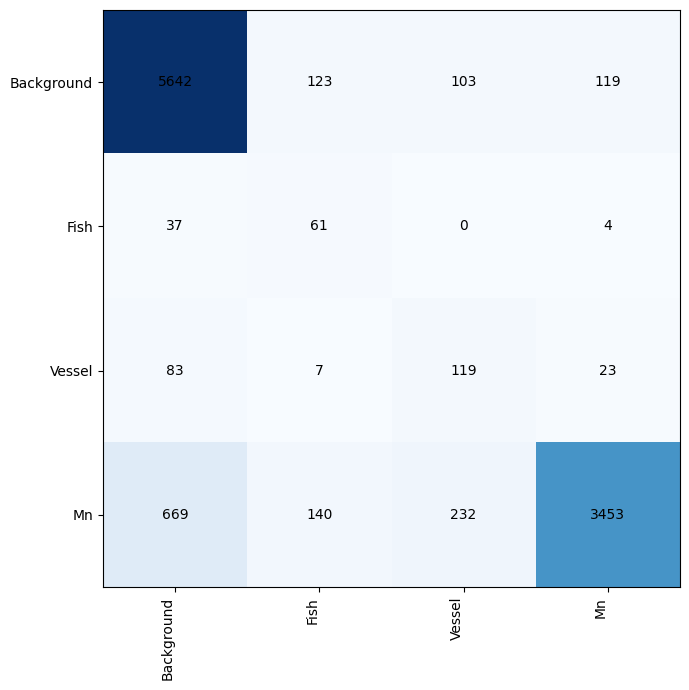

In [81]:
train_loss, train_acc, confusion_matrix = evaluate_model(
    model, val_loader, loss_fn, return_confusion_matrix=True
)
print(f"{val_loss=}, {val_acc=}")
draw_confusion_matrix(confusion_matrix, val_set.classes)
# loss = (max(counter) / counter) ** .6, label_smoothing=0.1, dropout=0.1

val_loss=1.8792040185494856, val_acc=0.5816920943134536


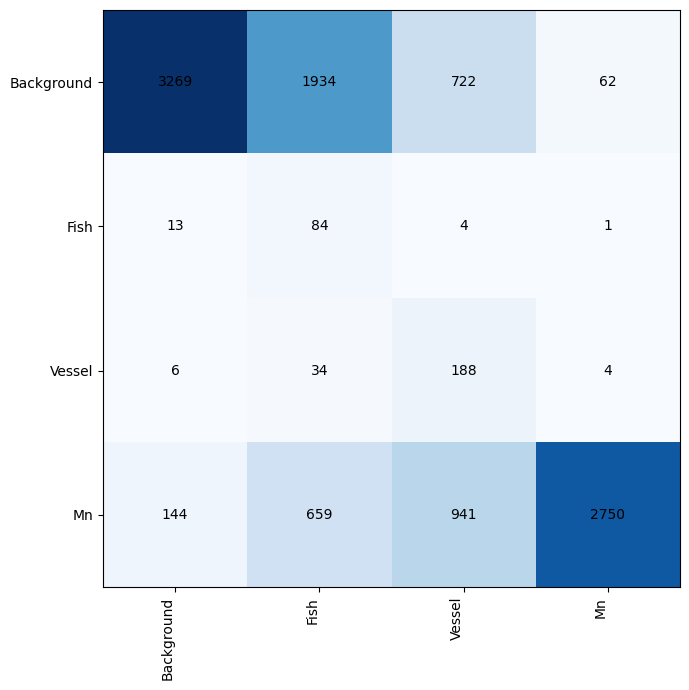

In [79]:
train_loss, train_acc, confusion_matrix = evaluate_model(
    model, val_loader, loss_fn, return_confusion_matrix=True
)
print(f"{val_loss=}, {val_acc=}")
draw_confusion_matrix(confusion_matrix, val_set.classes)
# loss = (max(counter) / counter) ** .7, label_smoothing=0.1, dropout=0.1